<center><h1>CSCI 4155 Project</h1></center>

<h4>Name : Yixiao Yuan B00785417</h4> 
<h4>Name : Kessel Zhang B00</h4>
<h4>Name : Tongqi Liu B00</h4>

### 1. Data  

#### 1.1  Get the data.

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# load csv files.
df_review = pd.read_csv('Reviews.csv')
df_review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
# a concise summary of a DataFrame .
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


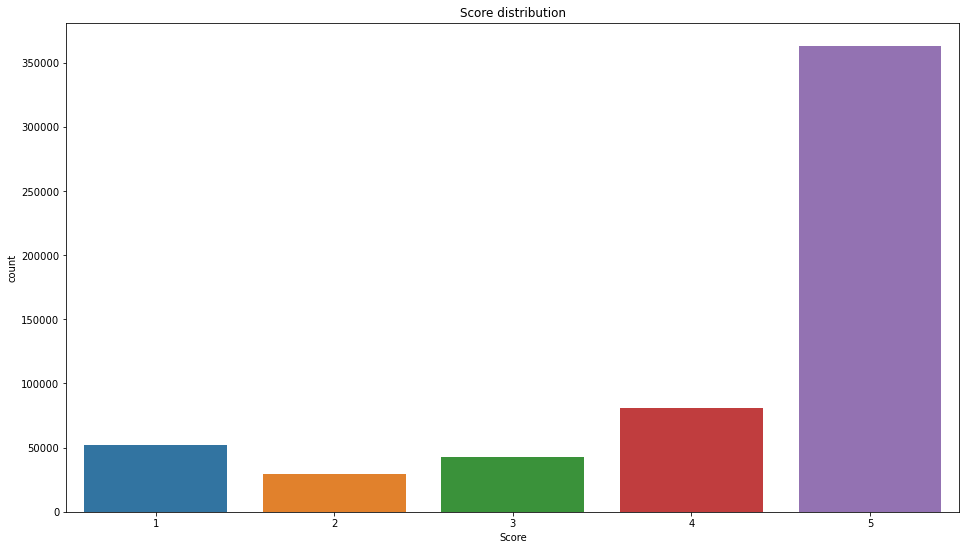

In [12]:
plt.figure(figsize=(16,9))
plt.title('Score distribution')
sns.countplot(data=df_review,x='Score')
plt.show()

#### 1.2.Data preprocessing


In [16]:
Reviews_Text =  df_review[['Text']]
Score = df_review['Score']

In [18]:
# Import the word tokenizer from nltk
from nltk.tokenize import word_tokenize
# Import stop word lexicon from nltk
from nltk.corpus import stopwords
# Import frequency distribution function from nltk
from nltk.probability import FreqDist
# import stemmer from nltk based on porter algorithm
from nltk.stem import PorterStemmer

# Count the frequency of words in a given text
def words_freq(text: str):
    # Tokenize into words, also splitting off some punctuation
    word_tokens = word_tokenize(text)

    # crate a vocabulary of stop words
    stop_words = set(stopwords.words('english'))

    # filter out stop word tokens
    filtered_words = [w for w in word_tokens if not w.lower() in stop_words]

    # remove numbers, punctuation marks, and individual letters
    words = [word.lower() for word in filtered_words if (word.isalpha() and len(word) > 1)]

    # # instantiate stemmer
    # ps = PorterStemmer()

    # # create new sentence with stemmed words
    # stemmed_words = [ps.stem(w) for w in  words]  

    # Count frequency of each token in the list
    # freqs = FreqDist(stemmed_words)
    freqs = FreqDist(words)

    return freqs


# Merge dictionaries and accumulate values
def merge_dict(d1: dict, d2: dict):
    for key,value in d2.items():
        if key in d1.keys():
            d1[key] += value
        else:
            d1[key] = value
    return d1


# Count the usage frequency of all words ('Text' column)
all_words_freq = {}
for row in df_review.itertuples():
    # count the frequency of words
    plot_text = getattr(row, 'Text')
    freqs = dict(words_freq(plot_text))

    # merge the frequency of words
    all_words_freq = merge_dict(all_words_freq, freqs)

# sort by word frequency
tmp_dict = all_words_freq.copy()
all_words_freq = dict(sorted(tmp_dict.items(), key=lambda x: x[1], reverse=True))

the distribution of the top 50 most frequent words (word,frequency):
('br', 647088) ('like', 252912) ('good', 197243) ('one', 174078) ('taste', 168346) ('great', 165352) ('coffee', 162816) ('product', 148350) ('flavor', 143939) ('tea', 135276) ('would', 135200) ('love', 127192) ('food', 125057) ('get', 108424) ('really', 100736) ('much', 92486) ('also', 86548) ('little', 83335) ('amazon', 83260) ('use', 83067) ('time', 81698) ('buy', 76509) ('tried', 76035) ('best', 75896) ('even', 74832) ('price', 74329) ('find', 73247) ('make', 71606) ('well', 69879) ('better', 69389) ('dog', 69093) ('try', 68267) ('eat', 66962) ('first', 61621) ('water', 59706) ('chocolate', 59337) ('could', 57182) ('bag', 56594) ('used', 54083) ('found', 53916) ('sugar', 53149) ('cup', 50935) ('drink', 50306) ('sweet', 50241) ('made', 49851) ('bought', 49786) ('box', 49278) ('think', 49035) ('way', 48648) ('two', 48382) 

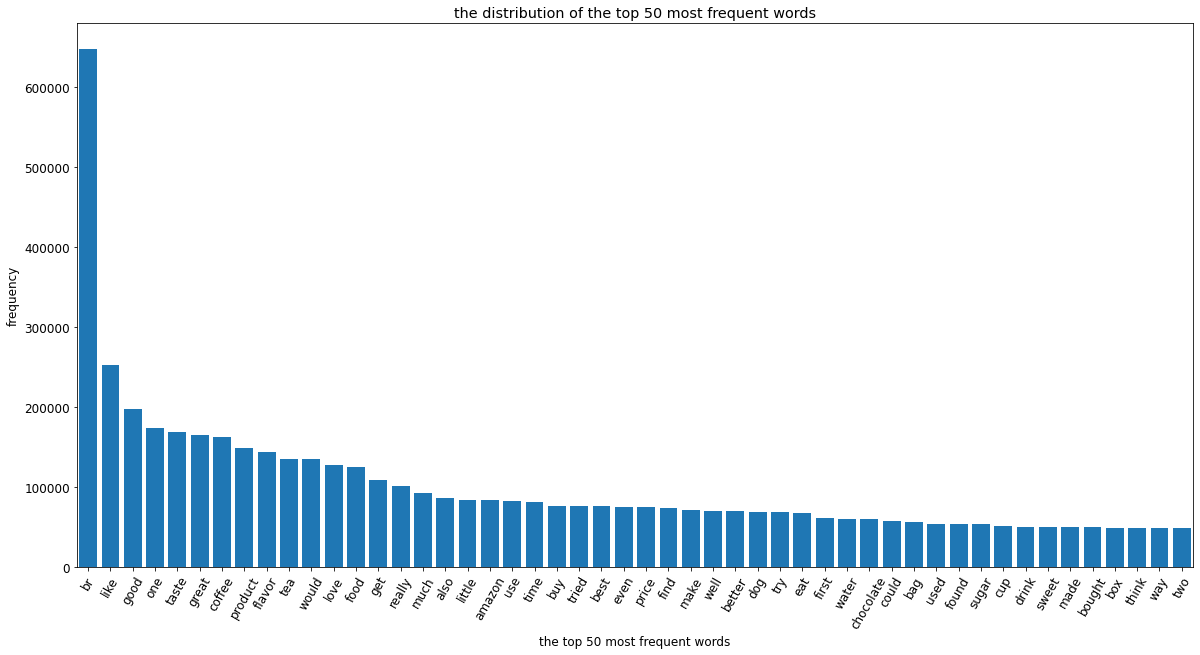

In [19]:
print('the distribution of the top 50 most frequent words (word,frequency):')

# find the top 50 most frequent words
word_list,freq_list = [],[]
i,n = 0,50
for key,value in all_words_freq.items():
    word_list.append(key)
    freq_list.append(value)
    
    i += 1
    print((key,value),end= " ")
    if (i >= n):
        break

# Drawthe distribution of the top 50 most frequent words
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["font.size"] = 12
plt.xticks(rotation=60)
plt.title("the distribution of the top 50 most frequent words")
plt.ylabel('frequency')
plt.xlabel('the top 50 most frequent words')
plt.bar(word_list,freq_list)
# plt.grid(True)
plt.xlim([-0.5,len(word_list)-0.5])
plt.show()

### Text normalization :

#### a. Remove stop words

#### b. Remove numbers and other non-letter characters

#### c. Perform either lemmatization or stemming.

#### d. Convert the corpus into a bag-of-words tf-idf weighted vector representation.

In [ ]:
# Import the word tokenizer from nltk
from nltk.tokenize import word_tokenize
# Import stop word lexicon from nltk
from nltk.corpus import stopwords
# Import frequency distribution function from nltk
from nltk.probability import FreqDist
# import stemmer from nltk based on porter algorithm
from nltk.stem import PorterStemmer
# Import the word pos_tag from nltk
from nltk import pos_tag

# calculate the frequency of words in a given text
#   Args:
#        text (str): [input text]
#        Stemming (bool): [= true, perform  stemming]
#        only_nouns (bool): [= true, using only the nouns]
#    Returns:
#        [type]: dictionary [the words used in text,In reverse order of frequency of use] 
def get_words_freq(text: str, Stemming: bool = False, only_nouns: bool = False):
    # Tokenize into words, also splitting off some punctuation
    word_tokens = word_tokenize(text)

    # using only the nouns
    if(only_nouns):
        noun_tag = ['NN','NNS','NNP']
        word_tag = pos_tag(word_tokens)
        word_tokens = [word[0] for word in word_tag if (word[1] in noun_tag)]

    # crate a vocabulary of stop words
    stop_words = set(stopwords.words('english'))

    # => a. Remove stop words
    # filter out stop word tokens
    filtered_words = [w for w in word_tokens if not w.lower() in stop_words]

    # => b. Remove numbers and other non-letter characters
    # remove numbers, punctuation marks, and individual letters
    words = [word.lower() for word in filtered_words if (word.isalpha() and len(word) > 1)]

    # => c. Perform  stemming. 
    if(Stemming):
        # instantiate stemmer
        ps = PorterStemmer()
        # create new sentence with stemmed words
        stemmed_words = [ps.stem(w) for w in  words]  

        # Count frequency of each token in the list
        freqs = FreqDist(stemmed_words)
        return dict(freqs)
    
    # => using only the nouns.
    if(only_nouns):
        freqs = FreqDist(words)
        return dict(freqs)

    freqs = FreqDist(words)
    return dict(freqs)

# Merge dictionaries and accumulate values
def merge_dict(d1: dict, d2: dict):
    for key,value in d2.items():
        if key in d1.keys():
            d1[key] += value
        else:
            d1[key] = value
    return d1

In [ ]:
# calculate the frequency of words in a given text lists
#   Args:
#        texts (list): [input text list]
#        Stemming (bool): [= true, perform  stemming]
#        only_nouns (bool): [= true, using only the nouns]
#    Returns:
#        [type]: dictionary [the words used in text list,In reverse order of frequency of use] 
#        [type]: dictionary [the words used in text,In reverse order of frequency of use] 
def get_texts_vector(texts: list, Stemming: bool, only_nouns: bool):
    each_words_freq = []
    all_words_freq ={}
    
    for plot_text in texts:
        # calculate the words and frequency of use in the movie plot
        plot_words_freq = get_words_freq(plot_text,Stemming,only_nouns)
            
        # sort by word frequency
        tmp_dict = plot_words_freq.copy()
        plot_words_freq = dict(sorted(tmp_dict.items(), key=lambda x: x[1], reverse=True))
        each_words_freq.append(plot_words_freq)
            
        # combine the words and frequency used for each movie
        all_words_freq = merge_dict(all_words_freq, plot_words_freq)

    # sort by word frequency
    tmp_dict = all_words_freq.copy()
    all_words_freq = dict(sorted(tmp_dict.items(), key=lambda x: x[1], reverse=True))
    
    return all_words_freq, each_words_freq


from sklearn.feature_extraction.text import TfidfTransformer

# CountVectorizer generates a matrix of the number of times each word appears.
def get_datas_vector(all_words_freq:dict, each_words_freq:list, top_words_size: int = 0, tfidf:bool =True):
    #
    datas_vector = []
    if(top_words_size > 0):
        top_words = list(all_words_freq.keys())[0:top_words_size]
    else:
        top_words = list(all_words_freq.keys())
    
    # CountVectorizer generates a matrix of the number of times each word appears.
    for e in each_words_freq:
        count_vector = np.zeros(len(top_words),dtype=int)
        for key,value in e.items():
            if(key in top_words):
                index = top_words.index(key)
                count_vector[index] = value
        datas_vector.append(count_vector)

    top_words = np.array(top_words)
    datas_vector = np.array(datas_vector)
    
    # a matrix of the tf-idf vector
    if(tfidf):
        transform = TfidfTransformer()    
        datas_vector = transform.fit_transform(datas_vector)
        datas_vector = np.array(datas_vector.toarray())
        
    return top_words,datas_vector
